In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os 
os.chdir("/content/drive/My Drive/fast.ai v3/section 2/cust_dl_lib")

!git config --global user.email "rajp152000@gmail.com"
!git config --global user.name "rajp152k"
!pip install fire
import fire
datasets_path = "/content/drive/My Drive/fast.ai v3/datasets"

In [3]:
!git pull

Already up to date.


this one's all about normalization

creating a control model and assessing performance

In [0]:
#export 
from exps.nb_06 import *

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train,y_train),Dataset(x_valid,y_valid)

In [0]:
nb,bs = 50,512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds,valid_ds,bs),c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback,mnist_view)]

In [0]:
nfs = [8,16,32,64,64]
# deeper this time

In [0]:
learn,run = get_learn_run(nfs,data,0.4,conv_layer,cbs = cbfs)

In [10]:
%time run.fit(2,learn)

train: [1.0499234375, tensor(0.6554, device='cuda:0')]
valid: [0.18995733642578125, tensor(0.9436, device='cuda:0')]
train: [0.18706517578125, tensor(0.9423, device='cuda:0')]
valid: [0.1061841796875, tensor(0.9683, device='cuda:0')]
CPU times: user 3.73 s, sys: 982 ms, total: 4.71 s
Wall time: 4.75 s


# Batchnorm

building a BatchNorm layer from scratch:
 - normalize
 - scale
 - shift 

that's all


In [0]:
class BatchNorm(nn.Module):
    def __init__(self,nf,mom=0.1,eps=1e-5):
        #pytorch's mom's work the opposite way
        #0.1 goes with the new term
        super().__init__()
        self.mom,self.eps = mom,eps
        #eps can be treated as a prominent hyperparameter as well
        #to control explosions for a closely knit batch
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        #scaler
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        #shifter
        self.register_buffer('vars',torch.ones(1,nf,1,1))
        self.register_buffer('means',torch.zeros(1,nf,1,1))
        # lookup documentation for working of register_buffer

    def update_stats(self,x):
        # computing stats across the batch,height and width
        # leaving channels of an image's activations as they are 
        m = x.mean((0,2,3),keepdim=True)
        #keeping dimensions for future broadcasts
        v = x.var((0,2,3),keepdim=True)
        self.means.lerp_(m,self.mom)
        self.vars.lerp_(m,self.mom)
        # lerp is linear interpolation:
        # for the exponential weighted average..
        return m,v

    def forward(self,x):
        if self.training:
            with torch.no_grad():m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        # during inference, need to store a running average 
        # of the statistics to be able to pass through the 
        # layers
        x = (x-m)/(v+self.eps).sqrt()
        return x*self.mults + self.adds

In [0]:
def conv_layer(ni,nf,ks=3,stride=2,bn=True,**kwargs):
    # the preexisting bias is unnecessary when using batchnorm
    layers = [nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride,bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)        

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)


In [0]:
learn,run = get_learn_run(nfs,data,0.9,conv_layer,cbs=cbfs)

hooking into the layers so the see the effects on the statistics

train: [0.25917158203125, tensor(0.9208, device='cuda:0')]
valid: [19.5394375, tensor(0.7805, device='cuda:0')]


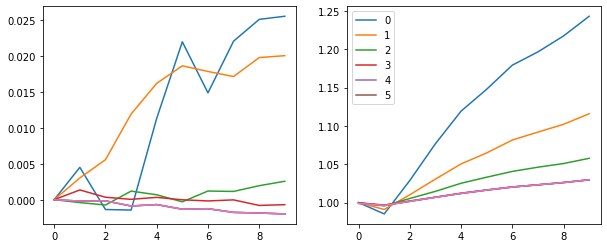

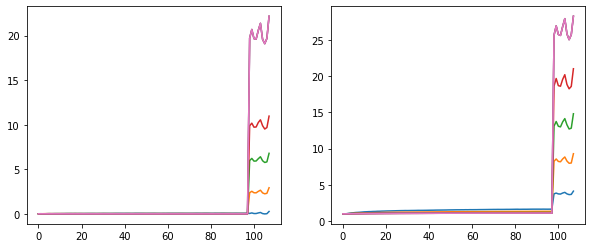

In [15]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

something's not right

In [0]:
learn,run = get_learn_run(nfs,data,1.0,conv_layer,cbs=cbfs)

In [17]:
%time run.fit(3,learn)

train: [0.25343095703125, tensor(0.9233, device='cuda:0')]
valid: [5.566601953125, tensor(0.8474, device='cuda:0')]
train: [0.0794063818359375, tensor(0.9764, device='cuda:0')]
valid: [16.6611671875, tensor(0.7873, device='cuda:0')]
train: [0.055969833984375, tensor(0.9830, device='cuda:0')]
valid: [15.2607359375, tensor(0.8498, device='cuda:0')]
CPU times: user 2.78 s, sys: 371 ms, total: 3.15 s
Wall time: 3.19 s


not training as expected with the custom batch norm : will return to address this later: proceeding wiht the built in batch norm now

## nn.Batchnorm

In [0]:
#export 
def conv_layer(ni,nf,ks=3,stride=2,bn=True,**kwargs):
    # no bias when bn=True
    layers=[nn.Conv2d(ni,nf,ks,padding=ks//2,stride=stride,bias=not bn),
            GeneralRelu(**kwargs)]
    if bn:layers.append(nn.BatchNorm2d(nf,eps=1e-5,momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs,data,1.,conv_layer,cbs=cbfs)

In [20]:
%time run.fit(3,learn)

train: [0.2100974609375, tensor(0.9356, device='cuda:0')]
valid: [0.09059398803710937, tensor(0.9730, device='cuda:0')]
train: [0.0603071435546875, tensor(0.9819, device='cuda:0')]
valid: [0.0756244873046875, tensor(0.9759, device='cuda:0')]
train: [0.0415101025390625, tensor(0.9870, device='cuda:0')]
valid: [0.06856533813476562, tensor(0.9785, device='cuda:0')]
CPU times: user 2.59 s, sys: 375 ms, total: 2.96 s
Wall time: 3 s


this is doing well

scheduling the learning rate now

In [21]:
sched = combine_scheds([0.3,0.7],[sched_cos(0.5,2.),sched_cos(2.,0.1)])
sched

<function exps.nb_05.combine_scheds.<locals>._inner>

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [23]:
run.fit(8,learn)

train: [0.27474361328125, tensor(0.9176, device='cuda:0')]
valid: [0.17283856201171874, tensor(0.9462, device='cuda:0')]
train: [0.096689296875, tensor(0.9697, device='cuda:0')]
valid: [0.13355640869140625, tensor(0.9560, device='cuda:0')]
train: [0.057703662109375, tensor(0.9814, device='cuda:0')]
valid: [0.062452203369140626, tensor(0.9819, device='cuda:0')]
train: [0.0375112744140625, tensor(0.9879, device='cuda:0')]
valid: [0.05889285278320312, tensor(0.9827, device='cuda:0')]
train: [0.02270995361328125, tensor(0.9931, device='cuda:0')]
valid: [0.043072265625, tensor(0.9890, device='cuda:0')]
train: [0.01161931640625, tensor(0.9971, device='cuda:0')]
valid: [0.04301170043945313, tensor(0.9885, device='cuda:0')]
train: [0.0068144091796875, tensor(0.9986, device='cuda:0')]
valid: [0.04201949462890625, tensor(0.9885, device='cuda:0')]
train: [0.005073502807617187, tensor(0.9993, device='cuda:0')]
valid: [0.04208524169921875, tensor(0.9886, device='cuda:0')]


way better

# Problems with batch norm

 - for small batch sizes, there is a high probability that the batch's statistics won't be close to that of the overall statistics along with the possibility of being close together--> leading to low variance hence exploding the normalized activations
 - this doesn't allow the model to train as effectively or at all
 - epsilon does help control this to an extent but just as in the case using of exponentially weighted running averages (for means and standard deviations) when interpreting, the same can be done when training with small batches to avoid this

#### control model to check improvements later on 
(using pytorch's default)

In [0]:
data = DataBunch(*get_dls(train_ds,valid_ds,2),c)

In [0]:
def conv_layer(ni,nf,ks=3,stride=2,bn=True,**kwargs):
    layers = [nn.Conv2d(ni,nf,ks,stride=stride,padding=ks//2,bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf,eps=1e-5,momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs,data,0.4,conv_layer,cbs=cbfs)

In [27]:
%time run.fit(1,learn)

train: [2.3624046875, tensor(0.1638, device='cuda:0')]
valid: [2772303.4624, tensor(0.1511, device='cuda:0')]
CPU times: user 1min 9s, sys: 1.26 s, total: 1min 10s
Wall time: 1min 11s


bad...

### Running Batch norm(running averages for means and stds)

In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

this'll do better

In [49]:
!python3 notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to exps/nb_07.py
